<a href="https://colab.research.google.com/github/Natalkina/DataScience/blob/main/%22HW10_mnist_vgg_part2_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16;
from keras.applications.vgg16 import preprocess_input
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [75]:
from keras.datasets import fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [76]:
train_images.shape

(60000, 28, 28)

In [77]:
test_images.shape

(10000, 28, 28)

In [78]:
#normalize data
train_images = train_images / 255.0

test_images = test_images / 255.0

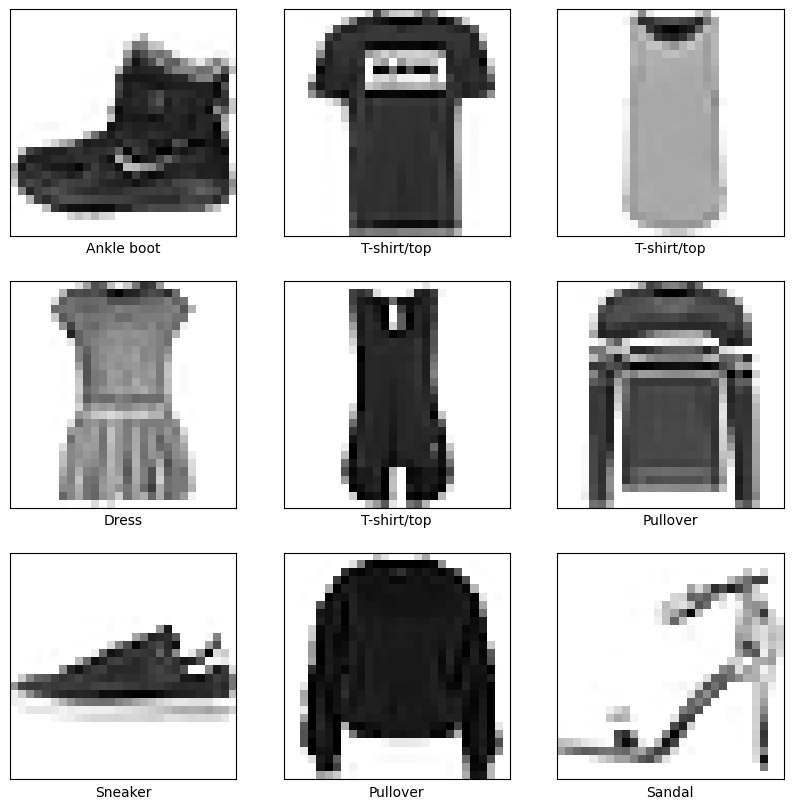

In [79]:
# lets see the data
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [80]:
#making 3 chanels
train_X = np.stack((train_images,) * 3, axis=-1)
test_X = np.stack((test_images,) * 3, axis=-1)
train_X.shape, test_X.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

In [81]:
#resize image for using VGG16
train_X = tf.image.resize(train_X, (48, 48))
test_X = tf.image.resize(test_X, (48, 48))

str(train_X.shape), str(test_X.shape)

('(60000, 48, 48, 3)', '(10000, 48, 48, 3)')

In [82]:
#converting labels to one hot encoded format
train_Y = to_categorical(train_labels, num_classes=10)
test_Y = to_categorical(test_labels, num_classes=10)

train_Y.shape, test_Y.shape

((60000, 10), (10000, 10))

In [83]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(48, 48, 3))

base_model.trainable = True
set_trainable = False
for layer in base_model.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False


In [84]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [85]:
#preprocessing
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
datagen.fit(train_X)


In [86]:
model = Sequential([
   base_model,
   Flatten(),
   Dense(512, activation="relu"),
   Dropout(0.3),
   Dense(10, activation="softmax"),
])

In [87]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [88]:
# Using the model
history = model.fit(
    datagen.flow(train_X, train_Y, batch_size=256),
    epochs=10,
    validation_data=(test_X, test_Y),
    steps_per_epoch=len(train_X) // 256,
    verbose=2)

Epoch 1/10
234/234 - 59s - loss: 0.7095 - accuracy: 0.7380 - val_loss: 0.4027 - val_accuracy: 0.8485 - 59s/epoch - 253ms/step
Epoch 2/10
234/234 - 57s - loss: 0.4650 - accuracy: 0.8299 - val_loss: 0.3978 - val_accuracy: 0.8545 - 57s/epoch - 244ms/step
Epoch 3/10
234/234 - 56s - loss: 0.4268 - accuracy: 0.8433 - val_loss: 0.3307 - val_accuracy: 0.8792 - 56s/epoch - 241ms/step
Epoch 4/10
234/234 - 55s - loss: 0.4077 - accuracy: 0.8506 - val_loss: 0.3589 - val_accuracy: 0.8662 - 55s/epoch - 235ms/step
Epoch 5/10
234/234 - 58s - loss: 0.3838 - accuracy: 0.8580 - val_loss: 0.3159 - val_accuracy: 0.8865 - 58s/epoch - 248ms/step
Epoch 6/10
234/234 - 55s - loss: 0.3797 - accuracy: 0.8596 - val_loss: 0.3201 - val_accuracy: 0.8848 - 55s/epoch - 233ms/step
Epoch 7/10
234/234 - 56s - loss: 0.3616 - accuracy: 0.8666 - val_loss: 0.3113 - val_accuracy: 0.8894 - 56s/epoch - 241ms/step
Epoch 8/10
234/234 - 55s - loss: 0.3585 - accuracy: 0.8672 - val_loss: 0.3351 - val_accuracy: 0.8810 - 55s/epoch - 236

In [91]:
# Testing accuracy evaluation
test_loss, test_accuracy = model.evaluate(test_X, test_Y, verbose=2)
print(f"Test accuracy: {test_accuracy}")


313/313 - 4s - loss: 0.3162 - accuracy: 0.8849 - 4s/epoch - 11ms/step
Test accuracy: 0.8848999738693237


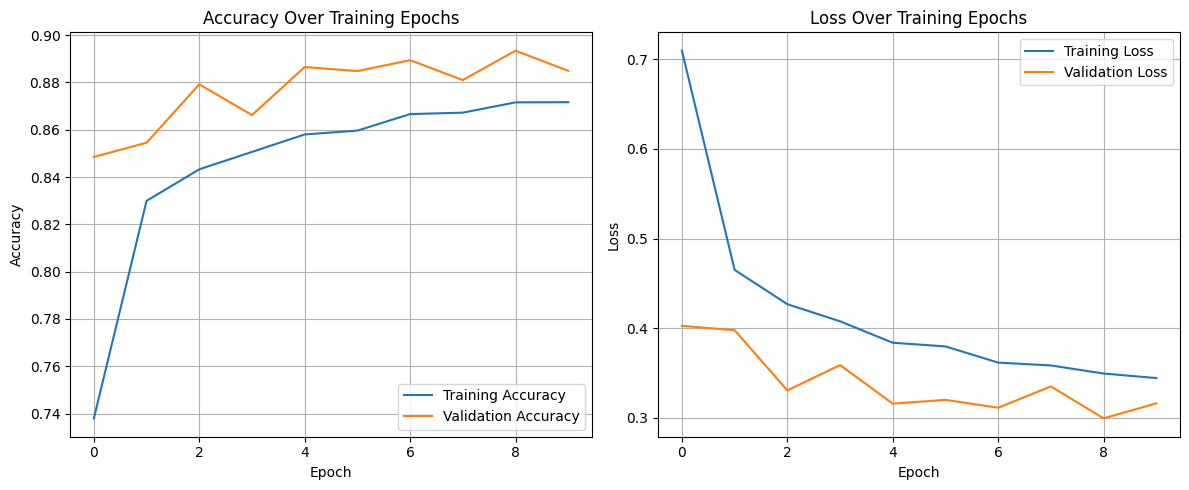

In [92]:
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Training Epochs')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Training Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [94]:
from sklearn.metrics import classification_report

test_predictions = model.predict(test_X)
predicted_classes = np.argmax(test_predictions, axis=1)

report = classification_report(test_labels, predicted_classes, target_names=class_names)
print(report)

313/313 [==============================] - 4s 11ms/step
              precision    recall  f1-score   support

 T-shirt/top       0.91      0.77      0.83      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.84      0.84      0.84      1000
       Dress       0.90      0.86      0.88      1000
        Coat       0.73      0.89      0.81      1000
      Sandal       0.99      0.95      0.97      1000
       Shirt       0.68      0.67      0.67      1000
     Sneaker       0.94      0.94      0.94      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.94      0.97      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.89     10000
weighted avg       0.89      0.88      0.89     10000



Таким чином використання вже готових моделей,  дозволяє покращити точнічність моделі, однак не завжди дати кращий результат, якщо додаткові параметри моделі досить прості